## <center> **Ripple Effect Strategy**  
We remove the multiprocessing feature to reduce memory load and complexity.  
This notebook

1. Loads Binance trades and HyperLiquid LOB snapshots.  
2. Identifies "significant trades" on Binance.  
3. Aligns those trades to LOB snapshots.  
4. Uses a **single-process** backtest loop with **tqdm** for progress.  
5. Implements **dynamic sizing** via half-Kelly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import json
import os

import concurrent
from collections import defaultdict

from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# For cleaner pandas output
pd.set_option('expand_frame_repr', False)

We use a **half-Kelly** approach for bet sizing
$$
f_{\mathrm{kelly}} = 0.5 \times \frac{p\,(b+1) - 1}{b}
$$
and cap at some max fraction, converting to coin quantity from total capital.

In [53]:
def half_kelly(
    trade_size: float,
    capital: float,
    entry_price: float,
    p: float = 0.75,
    b: float = 0.1,
    max_fraction: float = 0.05,
    min_qty: float = 0.0,
    max_qty: float = 1_000_000.0
) -> float:
    """
    Computes a half-Kelly fraction for dynamic sizing, then clamps
    the resulting coin quantity to [min_qty, max_qty].

    - half-kelly fraction:
       raw_kelly = 0.5 * ((p*(b+1) - 1) / b)
    - final coin quantity = fraction_of_capital * capital / entry_price
    - clamp the coin quantity to [min_qty, max_qty]
    """
    # half-Kelly fraction
    raw_kelly = 0.5 * ((p*(b+1) - 1) / b)
    if raw_kelly <= 0:
        return 0.0

    scale_factor = trade_size
    fraction_of_capital = min(raw_kelly * scale_factor, max_fraction)

    if entry_price <= 0:
        return 0.0

    raw_order_qty = fraction_of_capital * (capital / entry_price)
    order_qty = max(min_qty, min(raw_order_qty, max_qty))
    return order_qty

In [54]:
def backtest(
    significant_trades_aligned: pd.DataFrame,
    hl_book_processed: pd.DataFrame,
    taker_fee: float = 0.0003,
    profit_threshold_multiple: float = 1.5,
    capital: float = 10_000.0,
    min_size: float = 0.05,
    max_size: float = 0.2,
    max_holding_period: int = 200,
    imb_threshold_long: float = -0.3, # Must be < 0.3 to go long
    imb_threshold_short: float = 0.3 # Must be > 0.3 to go short
):
    """
    Sequential backtest using half-Kelly dynamic sizing and imbalance signal.
    """
    # Sort
    significant_trades_aligned = significant_trades_aligned.sort_values('aligned_index')

    # Pre-extract columns for speed
    BidPrice1_array = hl_book_processed['BidPrice_1'].values
    AskPrice1_array = hl_book_processed['AskPrice_1'].values
    Imbalance_array = hl_book_processed['Imbalance'].values # approx 1 => strong sell pressure; approx -1 => strong buy pressure
    n_rows = len(hl_book_processed)

    # We'll iterate trades in a single loop with tqdm
    total_profit = 0.0
    successful_trades = 0
    failed_trades = 0
    skipped_trades = 0
    trade_results = []

    # Convert the DataFrame to a list of tuples to speed up iteration
    trades_data = list(significant_trades_aligned.itertuples())

    for trade in tqdm(trades_data, desc="Backtest with Imbalance"):
        aligned_index = trade.aligned_index
        is_buyer_maker = trade.is_buyer_maker
        trade_size = trade.quantity

        # Attempt to retrieve top-of-book from pre-extracted arrays
        try:
            # Get book state at trade alignment
            current_imbalance = Imbalance_array[aligned_index]

            if is_buyer_maker:
                # Sell => short
                entry_price = BidPrice1_array[aligned_index]
                exit_price_type = 'AskPrice_1'
                direction = -1

                # Imbalance filter for shorts
                if current_imbalance < imb_threshold_short:
                    skipped_trades += 1
                    continue

            else:
                # Buy => long
                entry_price = AskPrice1_array[aligned_index]
                exit_price_type = 'BidPrice_1'
                direction = 1

                # Imbalance filter for longs
                if current_imbalance > imb_threshold_long:
                    skipped_trades += 1
                    continue

        except IndexError:
            skipped_trades += 1
            continue

        # half-Kelly dynamic quantity
        order_qty = half_kelly(
            trade_size=trade_size,
            capital=capital,
            entry_price=entry_price,
            p=0.75,
            b=1.0,
            max_fraction=0.05,
            min_qty=min_size,
            max_qty=max_size
        )
        if order_qty == 0.0:
            skipped_trades += 1
            continue

        per_unit_entry_fee = entry_price * taker_fee
        profit_threshold = per_unit_entry_fee * profit_threshold_multiple

        max_holding_rows = max_holding_period # Millisecond max holding period
        exit_found = False

        # searching forward for exit
        for idx in range(aligned_index + 1, min(aligned_index + 1 + 10_000, n_rows)):
            # you can limit how far you look in a single pass to avoid huge overhead
            if exit_price_type == 'AskPrice_1':
                exit_price = AskPrice1_array[idx]
            else:
                exit_price = BidPrice1_array[idx]

            price_change = (exit_price - entry_price) * direction

            # Check profit threshold
            if price_change > profit_threshold:
                profit = price_change * order_qty - (per_unit_entry_fee * order_qty)
                total_profit += profit
                successful_trades += 1
                trade_results.append({
                    'type': 'success',
                    'profit': profit,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'order_quantity': order_qty,
                    'aligned_index': aligned_index
                })
                exit_found = True
                break

            # Check max hold
            if (idx - aligned_index) > max_holding_rows:
                profit = price_change * order_qty - (per_unit_entry_fee * order_qty)
                total_profit += profit
                failed_trades += 1
                trade_results.append({
                    'type': 'failure',
                    'profit': profit,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'order_quantity': order_qty,
                    'aligned_index': aligned_index
                })
                exit_found = True
                break

        if not exit_found:
            # If we exhaust the loop with no exit
            skipped_trades += 1

    total_executed = successful_trades + failed_trades
    win_rate = (successful_trades / total_executed) if total_executed else 0.0
    summary = {
        'Total Profit': total_profit,
        'Successful Trades': successful_trades,
        'Failed Trades': failed_trades,
        'Win Rate': win_rate,
        'Skipped': skipped_trades
    }
    return summary, trade_results

### Data Loading & Preprocessing

Here, we load Binance trades, HyperLiquid LOB data, parse top-of-book, and align significant trades.  

In [2]:
SYMBOL = 'SOL'
START_MONTH = 6
END_MONTH = 12
YEAR = 2024

In [7]:
#####################################
# 1) LOAD BINANCE TRADES MONTHLY    #
#####################################

def generate_binance_monthly_file_paths(symbol, year, start_month, end_month):
    return [
        f"C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/{symbol}/{symbol}USDT-trades-{year}-{month:02}.csv"
        for month in range(start_month, end_month + 1)
    ]

binance_file_paths = generate_binance_monthly_file_paths(SYMBOL, YEAR, START_MONTH, END_MONTH)

def load_binance_trades_monthly(file_path, chunksize=1_000_000):
    """
    Loads monthly Binance trade data from a CSV file in chunks.
    """
    try:
        for chunk in pd.read_csv(
            file_path,
            sep=",",
            header=None,
            names=["trade_id", "price", "quantity", "quote_quantity", "timestamp", "is_buyer_maker", "ignore"],
            chunksize=chunksize
        ):
            yield chunk
    except Exception as e:
        logging.error(f"Error loading {file_path}: {e}")
        return

binance_trades_list = []

for i, path in enumerate(binance_file_paths, start=1):
    logging.info(f"Loading Binance monthly file {i}/{len(binance_file_paths)}: {path}")
    month_chunks = [chunk for chunk in load_binance_trades_monthly(path)]
    if month_chunks:
        month_df = pd.concat(month_chunks, ignore_index=True)
        month_df['timestamp'] = pd.to_datetime(month_df['timestamp'], unit='ms')
        month_df.set_index('timestamp', inplace=True)
        month_df.sort_index(inplace=True)
        month_df = month_df[~month_df.index.duplicated(keep='last')]
        binance_trades_list.append(month_df)

if binance_trades_list:
    binance_trades = pd.concat(binance_trades_list, ignore_index=False)
    binance_trades.sort_index(inplace=True)
    logging.info(f"Final Binance trades shape: {binance_trades.shape}")
else:
    binance_trades = pd.DataFrame()
    logging.info("No Binance trade data loaded at all.")

print(binance_trades.head())

2025-01-26 15:31:12,881 - INFO - Loading Binance monthly file 1/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-06.csv
2025-01-26 15:31:22,746 - INFO - Loading Binance monthly file 2/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-07.csv
2025-01-26 15:31:42,791 - INFO - Loading Binance monthly file 3/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-08.csv
2025-01-26 15:32:15,057 - INFO - Loading Binance monthly file 4/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-09.csv
2025-01-26 15:32:33,476 - INFO - Loading Binance monthly file 5/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-10.csv
2025-01-26 15:32:59,192 - INFO - Loading Binance monthly file 6/7: C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/SOL/SOLUSDT-trades-2024-11.csv
2025

                          trade_id   price  quantity  quote_quantity  is_buyer_maker  ignore
timestamp                                                                                   
2024-06-01 00:00:00.897  572229100  165.65     2.410       399.21650           False    True
2024-06-01 00:00:01.460  572229101  165.65     1.501       248.64065           False    True
2024-06-01 00:00:01.637  572229102  165.65     0.090        14.90850           False    True
2024-06-01 00:00:01.656  572229103  165.65     0.360        59.63400           False    True
2024-06-01 00:00:01.722  572229104  165.65     0.132        21.86580           False    True


In [3]:
###################################
# 2) Process Monthly LOB Data     #
###################################
def process_lob_pq():
    def generate_lob_file_paths(symbol, year, start_month, end_month):
        file_paths = []
        month_days = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 
                    7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
        for month in range(start_month, end_month + 1):
            days = month_days[month]
            if month == 2:
                days = 29 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 28
            file_paths.extend([
                f"D:/data/{symbol}/monthly_pickled_data/{year}{month:02}/{year}{month:02}{day:02}.pkl"
                for day in range(1, days + 1)
            ])
        return file_paths

    hl_lob_paths = generate_lob_file_paths(SYMBOL, YEAR, START_MONTH, END_MONTH)

    def load_pickle(p):
        try:
            data = pd.read_pickle(p)
            return pd.DataFrame(data) if isinstance(data, list) else data
        except Exception as e:
            logging.error(f"Error loading {p}: {e}")
            return None

    # Directory to save monthly files
    output_dir = f"D:/data/processed_lob_data/{SYMBOL}"
    os.makedirs(output_dir, exist_ok=True)

    # Precompute month groupings
    monthly_data = defaultdict(list)

    for i, p in enumerate(hl_lob_paths, 1):
        if i == 1 or i % 50 == 0:
            logging.info(f"Processing LOB pickle {i}/{len(hl_lob_paths)}: {p}")
        
        df = load_pickle(p)
        if df is None or df.empty:
            continue

        # Direct JSON parsing optimization
        json_str = df.iloc[:, 0].astype(str)
        coins, times, levels = [], [], []
        for s in json_str:
            try:
                data = json.loads(s)['raw']['data']
                coins.append(data['coin'])
                times.append(data['time'])
                levels.append(data.get('levels', [[], []]))
            except:
                coins.append(None)
                times.append(None)
                levels.append([[], []])

        # Create DataFrame with vectorized datetime conversion
        df_norm = pd.DataFrame({
            'coin': coins,
            'time': pd.to_datetime(times, unit='ms', errors='coerce'),
            'levels': levels
        }).dropna(subset=['time']).sort_values('time')

        if df_norm.empty:
            continue

        # Vectorized level processing
        bids = [lvls[0] if isinstance(lvls, list) and len(lvls) > 0 else [] for lvls in df_norm['levels']]
        asks = [lvls[1] if isinstance(lvls, list) and len(lvls) > 1 else [] for lvls in df_norm['levels']]

        # Extract top level using vectorized operations
        def get_top_level(data, field):
            return np.array([(x[0].get(field, np.nan) if x else np.nan) for x in data], dtype=np.float32)

        bid_px = get_top_level(bids, 'px')
        bid_sz = get_top_level(bids, 'sz')
        ask_px = get_top_level(asks, 'px')
        ask_sz = get_top_level(asks, 'sz')

        # Compute derived metrics using vectorized operations
        with np.errstate(divide='ignore', invalid='ignore'):
            mid_price = (bid_px + ask_px) / 2
            imbalance = (ask_sz - bid_sz) / (ask_sz + bid_sz)
            microprice = np.divide(
                bid_sz * ask_px + ask_sz * bid_px,
                bid_sz + ask_sz,
                out=np.full_like(bid_px, np.nan),
                where=(bid_sz + ask_sz) != 0
            )

        # Create final DataFrame
        df_processed = pd.DataFrame({
            'coin': df_norm['coin'].values,
            'BidPrice_1': bid_px,
            'BidSize_1': bid_sz,
            'AskPrice_1': ask_px,
            'AskSize_1': ask_sz,
            'MidPrice': mid_price,
            'Imbalance': imbalance,
            'Microprice': microprice
        }, index=df_norm['time']).sort_index()

        # Downsample using optimized resampling
        df_downsampled = df_processed.resample('100ms').last().ffill()
        
        # Group by month using index properties
        month_key = df_downsampled.index[0].strftime('%Y%m')
        monthly_data[month_key].append(df_downsampled)

    # Parallelized file saving
    def save_month(data):
        month, dfs = data
        monthly_path = os.path.join(output_dir, f"{SYMBOL}_LOB_{month}.parquet.gz")
        pd.concat(dfs).to_parquet(monthly_path, compression='gzip', index=True)
        logging.info(f"Saved monthly data to {monthly_path}")

    # Use ThreadPoolExecutor for I/O bound operations
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(save_month, monthly_data.items())

In [4]:
# Run the processing function
process_lob_pq()

2025-01-26 15:11:39,504 - INFO - Processing LOB pickle 1/214: D:/data/SOL/monthly_pickled_data/202406/20240601.pkl
2025-01-26 15:15:17,086 - INFO - Processing LOB pickle 50/214: D:/data/SOL/monthly_pickled_data/202407/20240720.pkl
2025-01-26 15:19:03,886 - INFO - Processing LOB pickle 100/214: D:/data/SOL/monthly_pickled_data/202409/20240908.pkl
2025-01-26 15:22:55,795 - INFO - Processing LOB pickle 150/214: D:/data/SOL/monthly_pickled_data/202410/20241028.pkl
2025-01-26 15:26:55,345 - INFO - Processing LOB pickle 200/214: D:/data/SOL/monthly_pickled_data/202412/20241217.pkl
2025-01-26 15:28:26,391 - INFO - Saved monthly data to D:/data/processed_lob_data/SOL\SOL_LOB_202412.parquet.gz
2025-01-26 15:28:41,481 - INFO - Saved monthly data to D:/data/processed_lob_data/SOL\SOL_LOB_202410.parquet.gz
2025-01-26 15:28:42,670 - INFO - Saved monthly data to D:/data/processed_lob_data/SOL\SOL_LOB_202411.parquet.gz
2025-01-26 15:29:00,350 - INFO - Saved monthly data to D:/data/processed_lob_data/

In [5]:
# Directory to saved monthly files
output_dir = f"D:/data/processed_lob_data/{SYMBOL}"
os.makedirs(output_dir, exist_ok=True)

# Load and combine monthly Parquet files
all_parquet_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".parquet.gz")]
final_data_list = []

for f in all_parquet_files:
    logging.info(f"Loading monthly file: {f}")
    chunk = pd.read_parquet(f)
    final_data_list.append(chunk)

if final_data_list:
    hl_book_resampled = pd.concat(final_data_list, ignore_index=False)
    hl_book_resampled.sort_index(inplace=True)
    logging.info(f"Final LOB shape: {hl_book_resampled.shape}")
else:
    hl_book_resampled = pd.DataFrame()
    logging.info("No data loaded from monthly files.")

print(hl_book_resampled.head(2))
print(hl_book_resampled.tail(2))

2025-01-26 15:30:04,815 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202406.parquet.gz
2025-01-26 15:30:06,076 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202407.parquet.gz
2025-01-26 15:30:07,186 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202408.parquet.gz
2025-01-26 15:30:08,323 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202409.parquet.gz
2025-01-26 15:30:09,570 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202410.parquet.gz
2025-01-26 15:30:10,785 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202411.parquet.gz
2025-01-26 15:30:12,296 - INFO - Loading monthly file: D:/data/processed_lob_data/SOL\SOL_LOB_202412.parquet.gz
2025-01-26 15:30:36,898 - INFO - Final LOB shape: (180236714, 8)


                        coin  BidPrice_1  BidSize_1  AskPrice_1   AskSize_1    MidPrice  Imbalance  Microprice
time                                                                                                          
2024-06-01 00:00:01.900  SOL  165.759995       1.66  165.770004  161.789993  165.764999   0.979688  165.760086
2024-06-01 00:00:02.000  SOL  165.759995       1.66  165.770004  161.789993  165.764999   0.979688  165.760086
                        coin  BidPrice_1    BidSize_1  AskPrice_1  AskSize_1   MidPrice  Imbalance  Microprice
time                                                                                                          
2024-12-26 23:59:58.600  SOL  188.380005  2373.149902  188.389999      12.58  188.38501  -0.989454  188.389938
2024-12-26 23:59:58.700  SOL  188.380005   225.520004  188.389999      12.58  188.38501  -0.894330  188.389481


Process HL LOB, Resample, Identify Significant Trades, and Align

In [29]:
if not binance_trades.empty:
    start_t = pd.Timestamp('2024-06-01')
    end_t = pd.Timestamp('2024-12-26 23:59:59')
    binance_trades_rs = binance_trades.loc[start_t:end_t]
    if not binance_trades_rs.empty:
        q_threshold = binance_trades_rs['quantity'].quantile(0.999999)
        sig_trades = binance_trades_rs[binance_trades_rs['quantity'] > q_threshold]
    else:
        sig_trades = pd.DataFrame()
else:
    sig_trades = pd.DataFrame()

# Align trade timestamps
if not sig_trades.empty and not hl_book_resampled.empty:
    sig_trades_sorted = sig_trades.sort_index()
    shifted_times = sig_trades_sorted.index + pd.Timedelta(milliseconds=100)

    used_idx = set()
    aligned_indices = []
    aligned_timestamps = []
    valid_mask = []

    for t in shifted_times:
        idx = hl_book_resampled.index.searchsorted(t, side='left')
        while idx < len(hl_book_resampled) and idx in used_idx:
            idx += 1
        if idx < len(hl_book_resampled):
            aligned_indices.append(idx)
            aligned_timestamps.append(hl_book_resampled.index[idx])
            used_idx.add(idx)
            valid_mask.append(True)
        else:
            aligned_indices.append(None)
            aligned_timestamps.append(None)
            valid_mask.append(False)

    valid_mask = np.array(valid_mask)
    sig_trades_aligned = sig_trades_sorted[valid_mask].copy()
    sig_trades_aligned['aligned_index'] = np.array(aligned_indices)[valid_mask]
    sig_trades_aligned['aligned_timestamp'] = np.array(aligned_timestamps)[valid_mask]
else:
    sig_trades_aligned = pd.DataFrame()

logging.info(f"Number of significant trades aligned: {len(sig_trades_aligned)}")

2025-01-26 15:41:33,325 - INFO - Number of significant trades aligned: 69


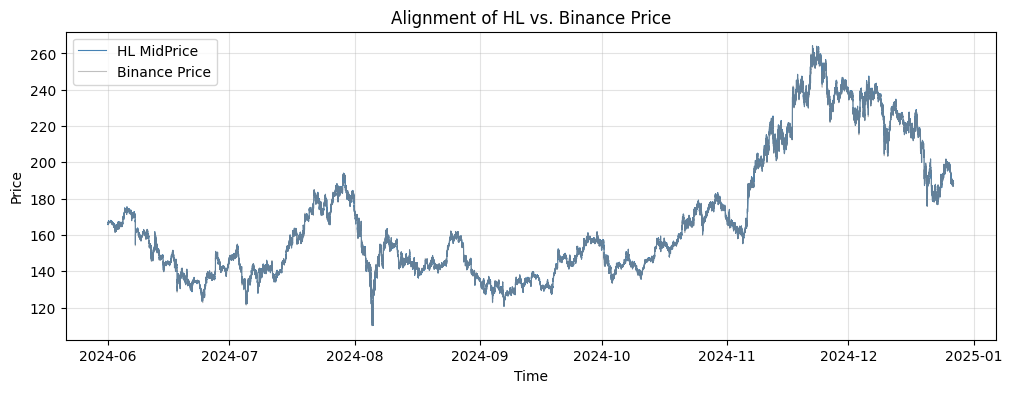

In [11]:
if not hl_book_resampled.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(hl_book_resampled[::1000].index, hl_book_resampled[::1000]['MidPrice'], label='HL MidPrice', lw=0.8, color='steelblue')
    if not binance_trades.empty:
        plt.plot(binance_trades_rs[::1000].index, binance_trades_rs[::1000]['price'], label='Binance Price', lw=0.8, color='gray', alpha=0.5)
    plt.title('Alignment of HL vs. Binance Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(alpha=0.35)
    plt.show()
else:
    print("No HL LOB data to plot.")

## Run the Backtest

2025-01-26 16:12:38,831 - INFO - Running backtest ...
2025-01-26 16:12:38,832 - INFO - Running with Profit Multiple: 5.0, Starting Capital: 10000.0
Backtest with Imbalance: 100%|██████████| 69/69 [00:00<00:00, 13337.34it/s]


Backtest Summary:
Total Profit: 5.7924
Successful Trades: 30
Failed Trades: 2
Win Rate: 93.75%
Skipped: 37

Trades Per Week: 1.07
Start Time: 2024-06-01 00:00:01.900000
End Time: 2024-12-26 23:59:58.700000

Annualized Sharpe: 5.5850


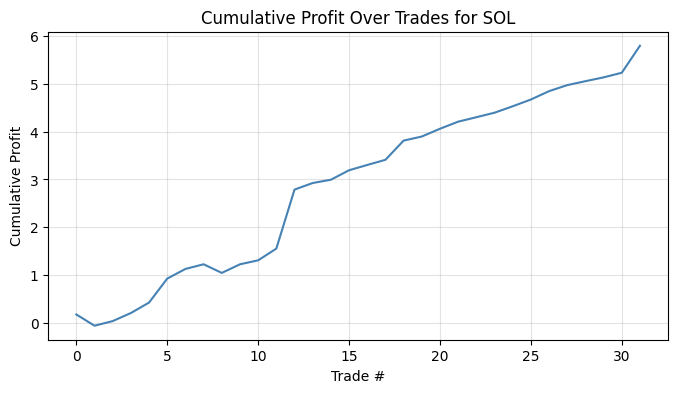

In [56]:
if not sig_trades_aligned.empty and not hl_book_resampled.empty:
    logging.info("Running backtest ...")

    TAKER_FEE = 0.00003 # 0.00019
    PROFIT_MULTIPLE = 5.0
    CAPITAL = 10_000.0
    logging.info(f"Running with Profit Multiple: {PROFIT_MULTIPLE} and Starting Capital: {CAPITAL}")
    summary, results = backtest(
        sig_trades_aligned,
        hl_book_resampled,
        taker_fee=TAKER_FEE,
        profit_threshold_multiple=PROFIT_MULTIPLE,
        capital=CAPITAL,
        min_size=1.0,
        max_size=10.0,
        max_holding_period=600,
        imb_threshold_long=-0.35,
        imb_threshold_short=0.35
    )
    print("\nBacktest Summary:")
    for k, v in summary.items():
        if k == 'Win Rate':
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
    # We store results in df_results to use in the next cell
    if results:
        df_results = pd.DataFrame(results)
        df_results['cumulative_profit'] = df_results['profit'].cumsum()
    else:
        df_results = pd.DataFrame()
else:
    print("Insufficient data for backtest.")
    summary = {}
    df_results = pd.DataFrame()

if 'df_results' in globals() and not df_results.empty:
    # Calculate returns as a fraction of capital
    capital = 10_000.0  # Your initial capital
    df_results['return'] = df_results['profit'] / capital

    # Calculate annualized Sharpe ratio
    returns = df_results['return']
    mean_return = returns.mean()
    return_std = returns.std()
    risk_free_rate = 0.0

    if return_std > 0:
        sharpe_ratio = (mean_return - risk_free_rate) / return_std
        start_time = hl_book_resampled.index.min()
        end_time = hl_book_resampled.index.max()
        total_seconds = (end_time - start_time).total_seconds()
        if total_seconds > 0:
            trades_per_second = len(df_results) / total_seconds
            trades_per_year = trades_per_second * 365 * 24 * 3600  # 365 days, 24/7
            sharpe_annualized = sharpe_ratio * np.sqrt(trades_per_year)
            print(f"\nTrades Per Week: {trades_per_second * 24 * 3600 * 7:.2f}")
            print(f"Start Time: {start_time}\nEnd Time: {end_time}")
        else:
            sharpe_annualized = float('nan')
    else:
        sharpe_ratio = float('nan')
        sharpe_annualized = float('nan')

    print(f"\nAnnualized Sharpe: {sharpe_annualized:.4f}")
    
    # Plot cumulative PnL
    plt.figure(figsize=(8,4))
    plt.plot(df_results.index, df_results['cumulative_profit'], color='steelblue')
    plt.title(f"Cumulative Profit Over Trades for {SYMBOL}")
    plt.xlabel("Trade #")
    plt.ylabel("Cumulative Profit")
    plt.grid(alpha=0.35)
    plt.show()
else:
    print("No results to plot or save.")